In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('Employee.csv')
df.drop_duplicates(inplace=True)

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

In [4]:
education_mapping = {'Bachelors': 0, 'Masters': 1, 'PHD': 2}
gender_mapping = {'Male': 0, 'Female': 1}
benched_mapping = {'No':0, 'Yes':1}

In [5]:
def encode_no_scaling(df, type='train'):
    df['Education'] = df['Education'].map(education_mapping)
    df['Gender'] = df['Gender'].map(gender_mapping)
    df['EverBenched'] = df['EverBenched'].map(benched_mapping)

    if type == 'train':
        cities_oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        cities_encoded = cities_oh.fit_transform(X_train[['City']])
        joblib.dump(cities_oh, 'city_OH_encoder.pkl')
    else:
        cities_oh = joblib.load('city_OH_encoder.pkl')
        cities_encoded = cities_oh.transform(df[['City']])

    
    cities_df = pd.DataFrame(cities_encoded, columns = cities_oh.get_feature_names_out(['City']))

    cities_df.index = df.index

    df.drop(columns='City', inplace=True)
    df = pd.concat([df, cities_df], axis=1)

    return df

In [6]:
X_train = encode_no_scaling(X_train, 'train')
X_test = encode_no_scaling(X_test, 'test')

In [49]:
rf = RandomForestClassifier(n_estimators=250, class_weight='balanced')
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.83      0.80       335
           1       0.70      0.60      0.65       218

    accuracy                           0.74       553
   macro avg       0.73      0.72      0.72       553
weighted avg       0.74      0.74      0.74       553



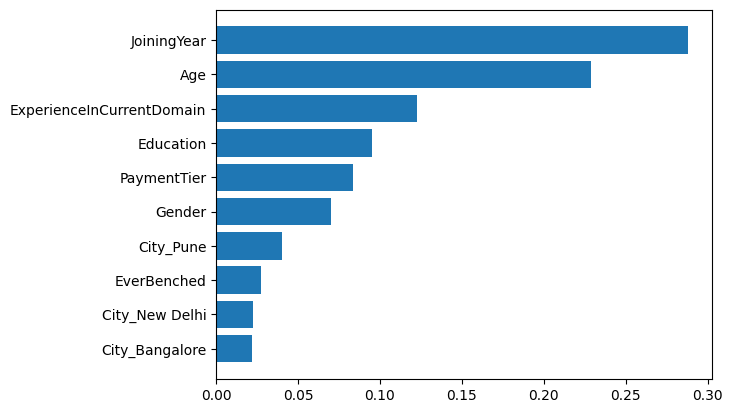

In [43]:
feature_importances = pd.DataFrame({'feature':X_train.columns, 'importance':rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance')
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.show()

In [26]:
100 * X_train[X_train['JoiningYear']==2018].shape[0]/X_train.shape[0]

8.412483039348711

EDA showed that almost all employees that joined in 2018 have left the company, which may negatively affect the generalization pattern of the model and also significantly contribute to the importance of joining year. It is also illogical that the joining year plays such a big role in the determining whether an employee will leave or not. Will try to fit the model to training data that does not include the employees that joined in 2018 (around 8.4% less training data).

In [45]:
X_train_no_2018 = X_train[X_train['JoiningYear']!=2018]
indices_no_2018 = X_train_no_2018.index

y_train_no_2018 = y_train.loc[indices_no_2018]

rf = RandomForestClassifier(n_estimators=550, class_weight='balanced')
rf.fit(X_train_no_2018, y_train_no_2018)

pred = rf.predict(X_test)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.68      0.84      0.75       335
           1       0.61      0.39      0.48       218

    accuracy                           0.66       553
   macro avg       0.65      0.62      0.62       553
weighted avg       0.65      0.66      0.64       553



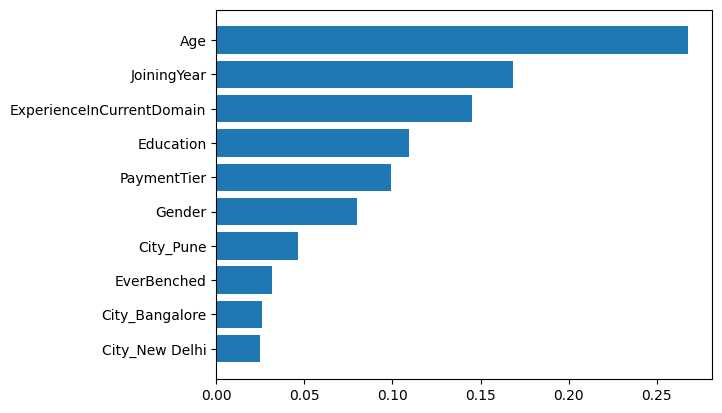

In [46]:
feature_importances = pd.DataFrame({'feature':X_train.columns, 'importance':rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance')
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.show()

As expected, the importance of joining year dropped by around 13%, but removing the employees that joined in 2018 caused the recall to drop by 21%, so models should be trained on the entire data (including employees joined in 2018)

<h2>XGBoost</h2>

In [19]:
import xgboost as xgb

In [58]:
X_xgb_train, X_xgb_valid, y_xgb_train, y_xgb_valid = train_test_split(X_train, y_train, random_state=0, train_size=0.9, stratify=y_train)
dtrain = xgb.DMatrix(X_xgb_train, label=y_xgb_train)
dvalid = xgb.DMatrix(X_xgb_valid, label=y_xgb_valid)

In [59]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

xgb_model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, 
                      early_stopping_rounds=15, verbose_eval=False)

y_pred_prob = xgb_model.predict(xgb.DMatrix(X_test))
pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       335
           1       0.86      0.64      0.73       218

    accuracy                           0.82       553
   macro avg       0.83      0.79      0.80       553
weighted avg       0.82      0.82      0.81       553



A significant improvement of 16% in precision compared to the random forest model, even though it's been trained on 10% less data (in order to avoid overfitting by evaluating performance on separate validation dataset). Recall increased only by 4%.


Presumably, either the number of samples in the dataset is not big enough in order to train a model that is able to generalize well on unseen data, or additional features that play a role in determining whether an employee would leave or not are needed to increase the recall.

<h2>Generating new training samples of minority class using SMOTE</h2>

In [85]:
minority_class_perc = 100 * y_xgb_train[y_xgb_train==1].shape[0] / y_xgb_train.shape[0]
print(f"Prior to oversampling, the minory class makes up {minority_class_perc: .2f}%")

Prior to oversampling, the minory class makes up  39.37%


In [86]:
oversample = SMOTE(sampling_strategy=0.9)
X_train_smote, y_train_smote = oversample.fit_resample(X_xgb_train, y_xgb_train)
minority_class_perc = 100 * y_train_smote[y_train_smote==1].shape[0] / y_train_smote.shape[0]
print(f"After oversampling, the minority class makes up {minority_class_perc: .2f}%")

After oversampling, the minority class makes up  47.36%


In [87]:
dtrain = xgb.DMatrix(X_train_smote, label=y_train_smote)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

xgb_model = xgb.train(params, dtrain, num_boost_round=1000, evals=evals, 
                      early_stopping_rounds=15, verbose_eval=False)

y_pred_prob = xgb_model.predict(xgb.DMatrix(X_test))
pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       335
           1       0.78      0.68      0.73       218

    accuracy                           0.80       553
   macro avg       0.80      0.78      0.79       553
weighted avg       0.80      0.80      0.80       553



Oversampling using SMOTE resulted in recall increase of 4%, while precision dropped by 8%. Since SMOTE resulted in a higher recall(target metric), <b>the final model will be XGBoost with 1000 rounds and early stopping rounds value of 15 with default learning rate, trained on SMOTE-augmented data with 47.36% ratio of minority class.</b> However, since SMOTE is non-deterministic and may also result in data that would not exist in real scenario, this <b>model should be taken with caution and monitored during exploitation</b>.